In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns

In [6]:
기상청_데이터 = pd.read_csv('../../Data/기상청/기온.csv',encoding = 'cp949')

기상청_데이터.fillna(0, inplace=True)


In [44]:
font_path = 'C:\\Windows\\Fonts\\gulim.ttc'
font = fm.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font)

강서_대여소_ID = pd.read_csv('../../Data/따릉이/강서_따릉이_대여소_ID.csv',encoding='utf-8')

강서_데이터1 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_01.csv',encoding='utf-8')
강서_데이터2 = pd.read_csv('../../Data/따릉이/강서_따릉이_데이터_02.csv',encoding='utf-8')

강서_데이터 = pd.concat([강서_데이터1, 강서_데이터2], ignore_index=True)
print(len(강서_데이터))
일별_강서_데이터= 강서_데이터.groupby('기준_날짜')['전체_건수'].sum()

일별_강서_데이터 = pd.DataFrame(일별_강서_데이터.items(), columns=['기준_날짜', '전체_건수'])
len(일별_강서_데이터)

3385613


241

In [45]:

# 휴일 데이터
휴일 = [
    {"날짜": "2023-05-05"},
    {"날짜": "2023-05-29"},
    {"날짜": "2023-06-06"},
    {"날짜": "2023-08-15"},
    {"날짜": "2023-09-28"},
    {"날짜": "2023-09-29"},
    {"날짜": "2023-10-02"},
    {"날짜": "2023-10-03"},
    {"날짜": "2023-10-09"},
    {"날짜": "2023-12-25"},
    {"날짜": "2024-01-01"},
    {"날짜": "2024-02-09"},
    {"날짜": "2024-02-12"},
    {"날짜": "2024-03-01"},
]
# 주말과 휴일을 분류하는 함수 정의
def classify_weekend_and_holidays(df, holidays):
    # '일시' 열을 datetime 형식으로 변환
    df['일시'] = pd.to_datetime(df['일시'])
    
    # 주말(토요일: 5, 일요일: 6)인지 여부를 나타내는 열 추가
    df['요일'] = df['일시'].dt.dayofweek  # 0: 월요일, 1: 화요일, ..., 6: 일요일
    df['주말'] = df['요일'].apply(lambda x: 1 if x >= 5 else 0)  # 토요일(5) 또는 일요일(6)이면 주말로 분류
    
    # 휴일인지 여부를 나타내는 열 추가
    df['휴일'] = df['일시'].apply(lambda x: 1 if str(x.date()) in [h['날짜'] for h in holidays] else 0)
    
    # 주말과 휴일으로 데이터 분리
    주말_df = df[(df['주말'] == 1) | (df['휴일'] == 1)]
    주중_df = df[(df['주말'] == 0) & (df['휴일'] == 0)]
    
    return 주말_df, 주중_df

# 함수 호출
기상청_주말_데이터, 기상청_주중_데이터 = classify_weekend_and_holidays(기상청_데이터, 휴일)
기상청_주중_데이터.rename(columns={'일시': '기준_날짜'}, inplace=True)
len(기상청_주중_데이터)


C:\Users\ciw96\AppData\Local\Temp\ipykernel_55664\663732242.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  기상청_주중_데이터.rename(columns={'일시': '기준_날짜'}, inplace=True)


246

In [15]:
# 기상청_주중_데이터의 '기준_날짜' 열을 datetime 형식으로 변환
기상청_주중_데이터['기준_날짜'] = pd.to_datetime(기상청_주중_데이터['기준_날짜'])

# 일별_강서_데이터의 '기준_날짜' 열을 datetime 형식으로 변환
일별_강서_데이터['기준_날짜'] = pd.to_datetime(일별_강서_데이터['기준_날짜'])

# 두 데이터프레임의 '기준_날짜' 값을 비교하여 있는 값과 없는 값을 구분
공통_날짜 = pd.merge(기상청_주중_데이터, 일별_강서_데이터, on='기준_날짜', how='inner')['기준_날짜']
기상청_누락_날짜 = 기상청_주중_데이터[~기상청_주중_데이터['기준_날짜'].isin(공통_날짜)]['기준_날짜']
강서_누락_날짜 = 일별_강서_데이터[~일별_강서_데이터['기준_날짜'].isin(공통_날짜)]['기준_날짜']

print("기상청 데이터에만 있는 날짜:")
print(기상청_누락_날짜)
기상청_주중_데이터 = 기상청_주중_데이터[~기상청_주중_데이터['기준_날짜'].isin(기상청_누락_날짜)]
기상청_주중_데이터 = 기상청_주중_데이터.rename(columns={'평균기온(°C)': '평균기온', '최고기온(°C)': '최고기온','최저기온(°C)': '최저기온'})



기상청 데이터에만 있는 날짜:
Series([], Name: 기준_날짜, dtype: datetime64[ns])


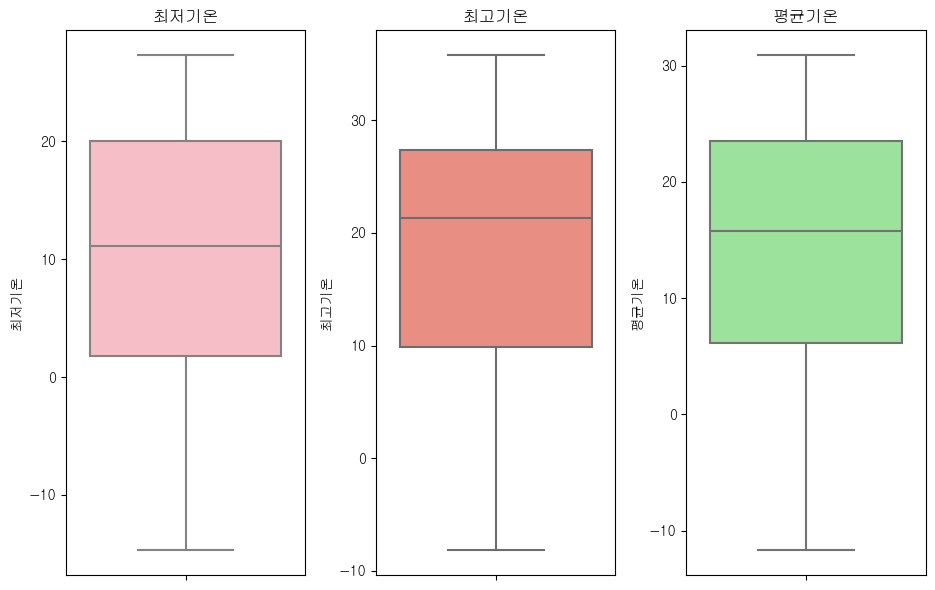

In [18]:

# 이상치를 보기 위해 기상 데이터와 강수량, 평균 기온, 초미세먼지를 병합
기상청 = pd.concat([기상청_주중_데이터[['최저기온', '최고기온',  '평균기온']], 일별_강서_데이터['전체_건수']], axis=1)

# Boxplot 그리기
plt.figure(figsize=(12, 6))


# 초미세먼지의 Boxplot
plt.subplot(1, 4, 2)
sns.boxplot(y=기상청['최저기온'], color='lightpink')
plt.title('최저기온')

# 강수량의 Boxplot
plt.subplot(1, 4, 3)
sns.boxplot(y=기상청['최고기온'], color='salmon')
plt.title('최고기온')

# 평균 기온의 Boxplot
plt.subplot(1, 4, 4)
sns.boxplot(y=기상청['평균기온'], color='lightgreen')
plt.title('평균기온')

plt.tight_layout()
plt.show()

In [24]:

# 기상청 데이터와 일별 데이터를 기준_날짜를 기준으로 병합
기상청_분석 = pd.merge(기상청_주중_데이터, 일별_강서_데이터, on='기준_날짜', how='inner')

기상청_분석

,지점,지점명,기준_날짜,평균기온,최저기온,최고기온,요일,주말,휴일,전체_건수
0,108,서울,2023-04-03,19.0,11.3,25.9,0,0,0,16354
1,108,서울,2023-04-04,17.6,12.7,21.7,1,0,0,13309
2,108,서울,2023-04-05,11.9,8.7,14.9,2,0,0,2191
3,108,서울,2023-04-06,8.8,7.4,9.7,3,0,0,7303
4,108,서울,2023-04-07,8.9,4.6,15.7,4,0,0,14320
...,...,...,...,...,...,...,...,...,...,...
236,108,서울,2024-03-25,10.6,6.7,14.5,0,0,0,6757
237,108,서울,2024-03-26,7.4,3.2,12.4,1,0,0,9299
238,108,서울,2024-03-27,10.4,4.4,16.2,2,0,0,15206
239,108,서울,2024-03-28,10.3,7.8,12.2,3,0,0,9280


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

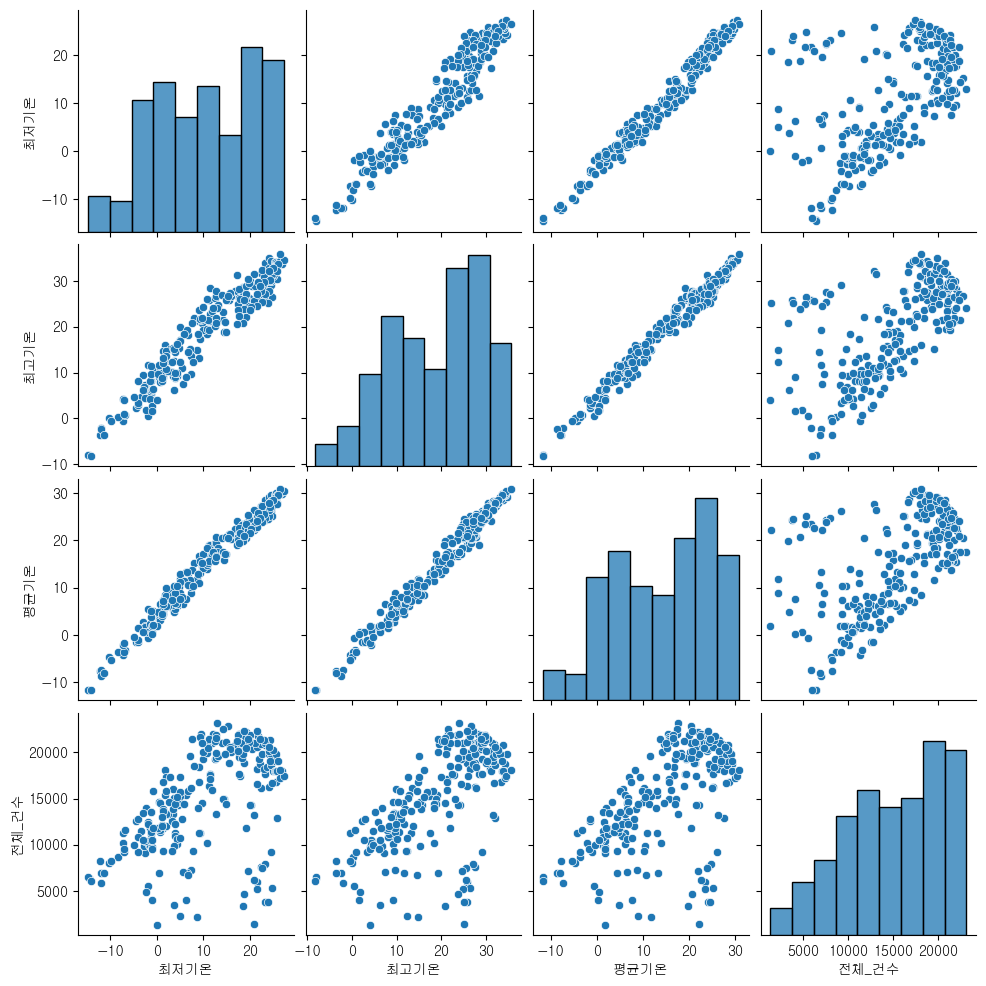

In [31]:


# 상관관계 계산
correlation_low_temperature = 기상청_분석['최저기온'].corr(기상청_분석['전체_건수'])
correlation_high_temperature= 기상청_분석['최고기온'].corr(기상청_분석['전체_건수'])
correlation_temperature = 기상청_분석['평균기온'].corr(기상청_분석['전체_건수'])
correlation_all = 기상청_분석[['최저기온','최고기온', '전체_건수', '평균기온']].corr()['전체_건수']

# 시각화    
sns.pairplot(기상청_분석[['최저기온','최고기온', '평균기온', '전체_건수']])
plt.show()

In [42]:
len(기상청_분석)

241

In [32]:
# 상관관계 출력
print("최저기온과 전체_건수의 상관관계:", correlation_low_temperature)
print("최고기온과 전체_건수의 상관관계:", correlation_high_temperature)
print("평균기온과 전체_건수의 상관관계:", correlation_temperature)
print("위 3가지와 전체_건수의 상관관계:")
print(correlation_all)

최저기온과 전체_건수의 상관관계: 0.5225687122284587
최고기온과 전체_건수의 상관관계: 0.6499794919421186
평균기온과 전체_건수의 상관관계: 0.5893370676231302
위 3가지와 전체_건수의 상관관계:
최저기온     0.522569
최고기온     0.649979
전체_건수    1.000000
평균기온     0.589337
Name: 전체_건수, dtype: float64


In [33]:
import statsmodels.api as sm

# 회귀 분석을 위한 데이터셋 준비
기상청_분석.dropna(inplace=True)  # 결측치가 있는 행 제거
X = 기상청_분석[['최고기온','최저기온', '평균기온']]
y = 기상청_분석['전체_건수']

# 상수항 추가
X = sm.add_constant(X)

# 회귀 모델 적합
model = sm.OLS(y, X).fit()

# 회귀 결과 요약
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  전체_건수   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     96.45
Date:                Mon, 06 May 2024   Prob (F-statistic):           7.90e-41
Time:                        16:14:22   Log-Likelihood:                -2319.1
No. Observations:                 241   AIC:                             4646.
Df Residuals:                     237   BIC:                             4660.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3353.6422    801.964      4.182      0.0

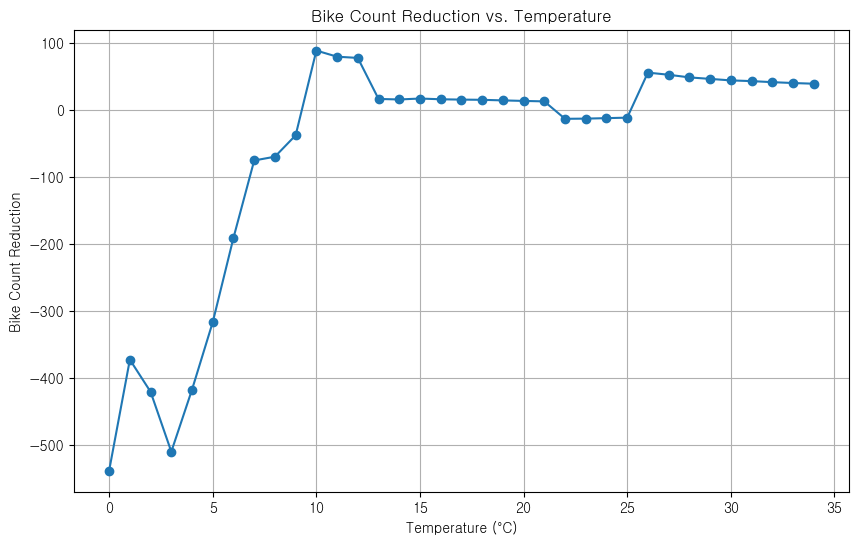

    기온(°C)      이용량_감소
0        0 -538.050588
1        1 -372.496561
2        2 -420.481857
3        3 -509.882627
4        4 -417.176695
5        5 -316.478872
6        6 -190.574486
7        7  -75.138333
8        8  -69.502958
9        9  -37.536780
10      10   88.931239
11      11   79.776553
12      12   77.960226
13      13   16.721894
14      14   15.925613
15      15   17.317587
16      16   16.223844
17      17   15.727196
18      18   15.412652
19      19   14.540238
20      20   13.761296
21      21   13.061570
22      22  -12.951351
23      23  -12.659215
24      24  -11.940962
25      25  -11.224504
26      26   56.035584
27      27   52.815148
28      28   48.882105
29      29   46.648913
30      30   44.395342
31      31   43.348282
32      32   41.771981
33      33   40.483858
34      34   39.441355


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
# ARIMA 모델을 학습하기 위한 시계열 데이터 준비
시계열_데이터 = 기상청_분석[[ '최고기온','전체_건수']]

# ARIMA 모델 학습
model = ARIMA(시계열_데이터['전체_건수'], order=(5,1,0)) # ARIMA 모델 생성
model_fit = model.fit() # 모델 학습

# 결과를 저장할 빈 리스트 생성
결과 = []

# 0°C부터 30°C까지의 기온 범위에 대해 반복문 실행
for 기온 in range(35):
    # 예측 결과에서 특정 기온 범위 내의 이용량 감소 확인
    특정_기온_범위_이용량 = model_fit.predict(start=0, end=len(기상청_분석)-1)
    특정_기온_범위_이용량 = 특정_기온_범위_이용량[기상청_분석['최고기온'] <= 기온]
    이용량_감소 = 특정_기온_범위_이용량.diff().dropna()
    
    # 결과를 딕셔너리 형태로 저장
    결과.append({
        '기온(°C)': 기온,
        '이용량_감소': 이용량_감소.mean() if len(이용량_감소) > 0 else 0
    })

# 결과를 DataFrame으로 변환
결과_df = pd.DataFrame(결과)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(결과_df['기온(°C)'], 결과_df['이용량_감소'], marker='o', linestyle='-')
plt.title('Bike Count Reduction vs. Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Bike Count Reduction')
plt.grid(True)
plt.show()

# 결과 출력
print(결과_df)

In [46]:
기상청_데이터

,지점,지점명,일시,평균기온(°C),최저기온(°C),최고기온(°C),요일,주말,휴일
0,108,서울,2023-04-01,17.5,9.4,25.6,5,1,0
1,108,서울,2023-04-02,18.8,11.9,25.2,6,1,0
2,108,서울,2023-04-03,19.0,11.3,25.9,0,0,0
3,108,서울,2023-04-04,17.6,12.7,21.7,1,0,0
4,108,서울,2023-04-05,11.9,8.7,14.9,2,0,0
...,...,...,...,...,...,...,...,...,...
361,108,서울,2024-03-27,10.4,4.4,16.2,2,0,0
362,108,서울,2024-03-28,10.3,7.8,12.2,3,0,0
363,108,서울,2024-03-29,7.6,5.0,12.3,4,0,0
364,108,서울,2024-03-30,8.8,3.0,15.6,5,1,0


In [48]:
# 최고기온을 5도 단위로 구간을 나누기 위한 함수 정의
def temperature_range(temperature):
    return int(temperature // 5) * 5

# 최고기온을 5도 단위로 구간을 나누고 '구간' 열에 할당
기상청_분석['구간'] = 기상청_분석['최고기온'].apply(temperature_range)


구간
-10     6297.000000
-5      7928.500000
 0      9063.809524
 5     11012.193548
 10    12204.482759
 15    15169.272727
 20    17309.108108
 25    17660.052632
 30    18836.411765
 35    18086.000000
Name: 전체_건수, dtype: float64


In [ ]:

# 각 구간별 전체_건수의 평균 계산
avg_counts_by_temperature_range = 기상청_분석.groupby('구간')['전체_건수'].mean()

print(avg_counts_by_temperature_range)

In [50]:
기상청_분석.to_csv('check1.csv',index=False)